<a href="https://colab.research.google.com/github/ggmeiner22/Estimating-Camera-Pose-from-a-Planar-Object/blob/main/EstimatingCameraPoseFromAPlanarObject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal

Given a calibrated camera (i.e., known intrinsics **K**) and a single image of a planar object, estimate the camera **pose** (i.e., extrinsics **R**, **t**).

I will:

1. build a Gradio UI to click 2D features and manage point order,
2. estimate pose **from a homography** (explicit derivation), and
3. estimate pose using **OpenCV** functions,
4. compare the two (short notes only).

Installs dependencies

In [225]:
%pip -q install opencv-python numpy gradio matplotlib

Imports

In [226]:
import json, io, math, os
import numpy as np
import cv2 as cv
import gradio as gr
import matplotlib.pyplot as plt
import glob


# For Image Grid Use
import os
filename = "plot_image_grid.py"
url = "https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py"
if not os.path.exists(filename):
    !wget {url}

from plot_image_grid import image_grid


from matplotlib.figure import Figure
from typing import List, Tuple, Dict, Any
import plotly.graph_objects as go         # Interactive plotting (3D/2D)

Camera Class

In [227]:
class Cam:
    """
    Camera-related utilities for calibration and pose handling.
    """

    @staticmethod
    def rodrigues_to_R(rvec: np.ndarray) -> np.ndarray:
        """
        Convert a Rodrigues rotation vector to a 3x3 rotation matrix.

        Args:
            rvec: Rotation vector (3x1 or 1x3), Rodrigues representation.

        Returns:
            R: Rotation matrix (3x3).
        """
        R, _ = cv.Rodrigues(rvec)
        return R

    @staticmethod
    def camera_center_in_board(rvec: np.ndarray, tvec: np.ndarray) -> np.ndarray:
        """
        Compute the camera center in the chessboard/world coordinate system.

        Uses the standard pinhole model:
            X_c = R * X_w + t
        → invert to get camera center in world coords:
            C_w = -R^T * t

        Args:
            rvec: Rotation vector (Rodrigues, 3x1).
            tvec: Translation vector (3x1).

        Returns:
            Camera center in board/world frame as a flat NumPy array (3,).
        """
        R = Cam.rodrigues_to_R(rvec)
        C = -R.T @ tvec.reshape(3, 1)
        return C.flatten()




# 1) Data and Calibration



 Download demo images

In [228]:
!git clone https://github.com/Penguini128/computer-vision-demo-images

fatal: destination path 'computer-vision-demo-images' already exists and is not an empty directory.


Auto-generate and save intrinsic parameters for demo locally

{'K': [[3139.0015479697936, 0.0, 1545.6609743626898], [0.0, 3432.1716395257067, 1956.7897029216788], [0.0, 0.0, 1.0]], 'distCoeffs': [[0.09632588463289136, 0.22821855282178258, -0.02150773740467271, 0.002057752891564199, -1.5481491836997736]]}


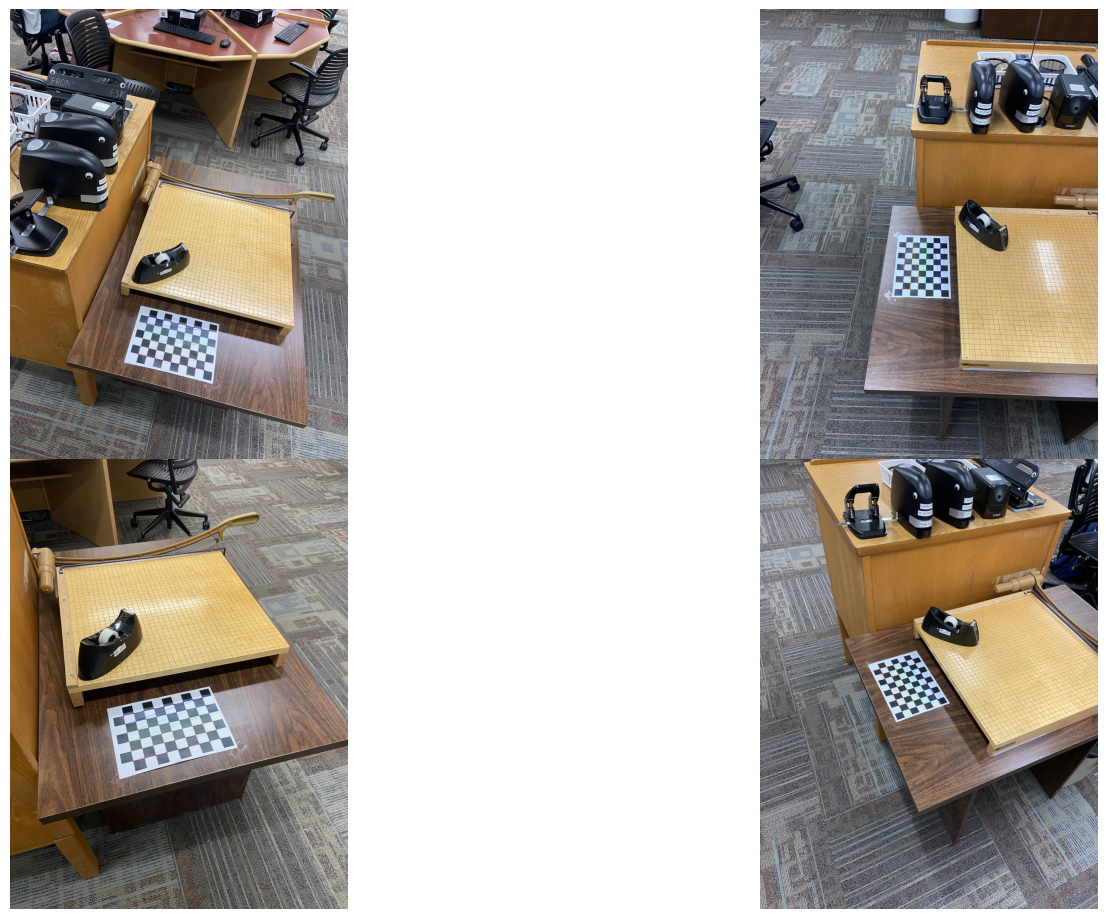

In [229]:
CHECKERBOARD = (9, 6)   # number of inner corners per a chessboard row and column
SQUARE_SIZE = 25.4*6/7       # set to real size of a square if you want results in real units
IMAGE_DIR = "computer-vision-demo-images/*.jpeg"  # path to your images
SAVE_FILE = "camera_params.npz"

# Create 3D points for the checkerboard corners, e.g. (0,0,0), (1,0,0), ...
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
# Scale points by SQUARE_SIZE
objp *= SQUARE_SIZE

# Arrays to store object points and image points
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

images = glob.glob(IMAGE_DIR)

rgb_images = []
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    if ret:
        objpoints.append(objp)
        # refine corner locations
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        imgpoints.append(corners2)


        cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        color_fixed = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        rgb_images.append(color_fixed)

image_grid(rgb_images[:4], rows=2, cols=2, rgb=True, show_axes=False)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

data = {
    'K' : mtx.tolist(),
    'distCoeffs' : dist.tolist()
}

print(data)


with open('intrinsics.json', 'w', encoding='utf-8') as f:
  json.dump(data, f, indent=4)


Intrinsics + Model Points

In [230]:
def load_intrinsics(json_path):
    """
    Expect JSON with keys:
      K: [[fx,0,cx],[0,fy,cy],[0,0,1]]
      distCoeffs: [k1,k2,p1,p2,k3] (length 4,5,8, or 12 acceptable)
    """
    with open(json_path, "r") as f:
        data = json.load(f)
    K = np.array(data["K"], dtype=float)
    dist = np.array(data.get("distCoeffs", []), dtype=float).reshape(-1,1) if data.get("distCoeffs") is not None else None
    return K, dist

def generate_checkerboard_points(cols, rows, square_size):
    """
    Returns planar model points (Z=0) in meters in row-major order of INNER corners.
    cols = number of inner corners along x, rows along y.
    """
    xs, ys = np.meshgrid(np.arange(cols), np.arange(rows))
    pts = np.stack([xs.ravel(), ys.ravel()], axis=1).astype(float) * float(square_size)
    return pts  # shape: (N,2), Z=0 implied


Pose from a homography (explicit derivation)

In [231]:
# ---------- Utilities: normalized DLT for Homography ----------
def _normalize_points_2d(pts):
    """
    Hartley normalization: translate to zero mean and scale so that
    the mean Euclidean distance from the origin is sqrt(2).
    Returns (T, pts_norm), where T is the 3x3 similarity transform.
    """
    pts = np.asarray(pts, float)
    assert pts.shape[1] == 2
    mean = pts.mean(axis=0)
    pts_c = pts - mean
    mean_dist = np.mean(np.sqrt(np.sum(pts_c**2, axis=1)))
    s = np.sqrt(2) / mean_dist if mean_dist > 0 else 1.0

    T = np.array([
        [s, 0, -s*mean[0]],
        [0, s, -s*mean[1]],
        [0, 0, 1.0]
    ], dtype=float)

    pts_h = np.hstack([pts, np.ones((len(pts),1))])
    pts_n = (T @ pts_h.T).T
    return T, pts_n[:, :2]

def _homography_dlt(model_pts_2d, image_pts_2d):
    """
    Compute H (3x3) such that  [u v 1]^T ~ H [X Y 1]^T
    using normalized DLT (no OpenCV).
    """
    X = np.asarray(model_pts_2d, float)
    x = np.asarray(image_pts_2d, float)
    assert X.shape[0] >= 4 and X.shape == x.shape and X.shape[1] == 2

    # Normalize both sets
    T_x, x_n = _normalize_points_2d(x)
    T_X, X_n = _normalize_points_2d(X)

    # Build design matrix A (2 rows per correspondence)
    N = X.shape[0]
    A = []
    for i in range(N):
        X_i, Y_i = X_n[i]
        u_i, v_i = x_n[i]
        A.append([0, 0, 0, -X_i, -Y_i, -1, v_i*X_i, v_i*Y_i, v_i])
        A.append([X_i, Y_i, 1, 0, 0, 0, -u_i*X_i, -u_i*Y_i, -u_i])
    A = np.asarray(A, float)

    # Solve Ah=0 via SVD (last singular vector)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    Hn = h.reshape(3,3)

    # Denormalize: x ~ T_x^{-1} * Hn * T_X * X
    H = np.linalg.inv(T_x) @ Hn @ T_X
    # Scale so that H[2,2] = 1 (optional; avoids huge scale)
    if abs(H[2,2]) > 1e-12:
        H = H / H[2,2]
    return H

# ---------- Pose from Homography (no OpenCV) ----------
def pose_from_homography(K, model_pts_2d, image_pts_2d):
    """
    Given intrinsics K and planar correspondences (X,Y,0) -> (u,v),
    compute pose [R|t] from homography, WITHOUT using OpenCV.

    Steps:
      1) H from normalized DLT:  x ~ H X
      2) B = K^{-1} H = [r1 r2 t] up to scale
      3) lambda from ||b1|| and ||b2||; r1 = lam*b1, r2 = lam*b2, r3 = r1 x r2
      4) Orthonormalize R via SVD; enforce det(R)=+1
      5) t = lam*b3
      6) Cheirality: flip sign so average depth of model points is positive
    Returns: (R, t, H)
    """
    K = np.asarray(K, float)
    H = _homography_dlt(model_pts_2d, image_pts_2d)

    # Remove intrinsics
    Kinv = np.linalg.inv(K)
    B = Kinv @ H

    b1, b2, b3 = B[:,0], B[:,1], B[:,2]

    # Scale lambda: use both columns for stability
    n1 = np.linalg.norm(b1)
    n2 = np.linalg.norm(b2)
    lam = 2.0 / (n1 + n2) if (n1 + n2) > 1e-12 else 1.0

    r1 = lam * b1
    r2 = lam * b2
    r3 = np.cross(r1, r2)

    R_approx = np.stack([r1, r2, r3], axis=1)

    # Orthonormalize (closest rotation) via SVD
    U, _, Vt = np.linalg.svd(R_approx)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        # Proper rotation
        U[:,-1] *= -1
        R = U @ Vt

    t = lam * b3.reshape(3,)

    # Cheirality: ensure points lie in front (positive depth)
    # Depth for a world point [X,Y,0,1]^T is: z = (R[2,:] @ [X,Y,0]) + t[2]
    X = np.asarray(model_pts_2d, float)
    depths = (R[2,0]*X[:,0] + R[2,1]*X[:,1] + t[2])
    if np.mean(depths) < 0:
        # Flip sign (projectively equivalent)
        R[:,0:2] *= -1
        t *= -1
        # Re-orthonormalize after flip just in case
        U, _, Vt = np.linalg.svd(R)
        R = U @ Vt
        if np.linalg.det(R) < 0:
            U[:,-1] *= -1
            R = U @ Vt

    return R, t, H


OpenCV Pose (solvePnP)

In [232]:
def pose_from_pnp(K, dist, model_pts_2d, image_pts_2d):
    """
    Uses solvePnP with planar points lifted to Z=0.
    model_pts_2d: (N,2) -> becomes (N,3) with Z=0
    image_pts_2d: (N,2)
    """
    obj3d = np.hstack([np.asarray(model_pts_2d, float), np.zeros((len(model_pts_2d),1), float)])
    img2d = np.asarray(image_pts_2d, float)

    ok, rvec, tvec = cv2.solvePnP(obj3d, img2d, K, dist if dist is not None and len(dist)>0 else None, flags=cv2.SOLVEPNP_ITERATIVE)
    if not ok:
        raise ValueError("solvePnP failed")

    R, _ = cv2.Rodrigues(rvec)
    # Ensure proper rotation
    U, _, Vt = np.linalg.svd(R)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:,-1] *= -1
        R = U @ Vt

    t = tvec.reshape(3,)
    return R, t

Projection + Overlay

In [233]:
def project_points_world_to_image(pts_w3d, K, dist, R, t):
    rvec, _ = cv2.Rodrigues(R)
    tvec = t.reshape(3,1)
    pts_img, _ = cv2.projectPoints(np.asarray(pts_w3d, float), rvec, tvec, K, dist if dist is not None and len(dist)>0 else None)
    return pts_img.reshape(-1,2)

def overlay_axes(image_bgr, K, dist, R, t, axis_len=0.05):
    """
    Draws XYZ axes at world origin (0,0,0) with length axis_len (meters).
    """
    img = image_bgr.copy()
    origin = np.array([[0,0,0]], dtype=float)
    axes = np.array([[axis_len,0,0],
                     [0,axis_len,0],
                     [0,0,axis_len]], dtype=float)

    origin_px = project_points_world_to_image(origin, K, dist, R, t)[0]
    axes_px = project_points_world_to_image(axes, K, dist, R, t)

    O = tuple(np.round(origin_px).astype(int))
    X = tuple(np.round(axes_px[0]).astype(int))
    Y = tuple(np.round(axes_px[1]).astype(int))
    Z = tuple(np.round(axes_px[2]).astype(int))

    cv2.line(img, O, X, (255,0,0), 2)
    cv2.line(img, O, Y, (0,255,0), 2)
    cv2.line(img, O, Z, (0,0,255), 2)
    return img

3D Camera Plot

In [234]:
def plot_camera_poses_3d(
    pose_list: List[Tuple[str, np.ndarray, np.ndarray]],
    square_size_m: float
):
    """
    Visualize estimated camera centers in the chessboard/world frame.

    Args:
        pose_list: List of (image_path, rvec, tvec) for each image with a solved pose.
                   rvec/tvec express the camera pose w.r.t. the board (world) frame.
        square_size_m: Real-world size of one chessboard square (for axis/grid scaling).

    Returns:
        Plotly Figure with:
          - A faint board grid lying on Z=0 (world XY plane)
          - Camera centers as markers labeled #0, #1, …
          - Board axes (X, Y, Z) drawn at the origin

    Notes:
        - World frame convention (from earlier):
            Board lies in Z=0; units are meters if `square_size_m` is in meters.
        - Camera center is computed as C_w = -R^T * t (already done upstream).
    """
    fig = go.Figure()
    if len(pose_list) == 0:
        # Nothing to plot → keep consistent aspect mode so axes don't distort
        fig.update_layout(title="No poses to display", scene_aspectmode='data')
        return fig


    # Camera centers
    centers, labels = [], []
    for pth, rvec, tvec in pose_list:
        C = Cam.camera_center_in_board(rvec, tvec)   # shape (3,)
        centers.append(C)                            # keep as array/list; we'll cast below
        labels.append(os.path.basename(pth))

    # Cast to NumPy BEFORE any [:, ...] indexing
    centers = np.asarray(centers, dtype=float)       # shape (N, 3)

    # Flip Z so cameras in front of the board appear at +Z (matches overlay)
    centers[:, 2] *= -1

    fig.add_trace(go.Scatter3d(
        x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
        mode="markers+text",
        text=[f"#{i}" for i in range(len(labels))],
        textposition="top center",
        marker=dict(size=4), name="Camera centers"
    ))

    # --- Board axes drawn at the origin (0,0,0) ---
    L = 3.0 * square_size_m  # axis length in world units
    axes = {
        "X": [[0, L], [0, 0], [0, 0]],
        "Y": [[0, 0], [0, L], [0, 0]],
        "Z": [[0, 0], [0, 0], [0, L]],
    }
    for name, (ax, ay, az) in axes.items():
        fig.add_trace(go.Scatter3d(x=ax, y=ay, z=az, mode="lines", name=f"{name}-axis"))

    # Keep aspect ratio true to data scale; label axes with units
    fig.update_layout(
        title="Estimated Camera Poses w.r.t. Chessboard",
        scene=dict(
            xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)",
            aspectmode="data"
        ),
        legend=dict(x=0, y=1.0)
    )
    return fig

In [235]:
# --- ROBUST CHESSBOARD AUTO-DETECT (drop-in replacement for on_auto_detect + helpers) ---
import cv2, numpy as np

def _maybe_undistort(bgr, K, dist):
    if K is None or dist is None or len(dist) == 0:
        return bgr, K
    h, w = bgr.shape[:2]
    newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 0)  # alpha=0 (crop)
    und = cv2.undistort(bgr, K, dist, None, newK)
    return und, newK

def _prep_variants(bgr):
    """Generate a few variants to help detection."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    v = []

    # base
    v.append(gray)

    # equalized
    v.append(cv2.equalizeHist(gray))

    # mild blur
    v.append(cv2.GaussianBlur(gray, (3,3), 0))

    # slightly downscaled (sometimes helps SB)
    small = cv2.resize(gray, None, fx=0.7, fy=0.7, interpolation=cv2.INTER_AREA)
    v.append(small)

    # inverted (white/black contrast reversal sometimes helps)
    v.append(255 - gray)

    return v

def _try_find(gray, pattern_size):
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    ok, corners = cv2.findChessboardCorners(gray, pattern_size, flags=flags)
    if ok and corners is not None:
        # refine on original scale only
        if gray.ndim == 2 and gray.shape[0] >= 50 and gray.shape[1] >= 50:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 60, 1e-6)
            cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
        return True, corners.reshape(-1,2).astype(np.float32)

    # SB fallback (often more robust)
    ok, corners = cv2.findChessboardCornersSB(gray, pattern_size, flags=0)
    if ok and corners is not None:
        return True, corners.reshape(-1,2).astype(np.float32)

    return False, None

def robust_auto_detect(bgr, cols, rows, K=None, dist=None, detect_on_undistorted=False):
    """
    Tries: raw/undistorted, multiple image variants, and a couple of nearby pattern sizes.
    Returns (ok, corners, used_cols, used_rows, used_K)
    """
    # Candidate inner-corner sizes (try requested first, then neighbors)
    sizes = [(int(cols), int(rows))]
    # Add a couple of nearby guesses (common off-by-one)
    neighbor_sizes = {(int(cols)-1, int(rows)),
                      (int(cols), int(rows)-1),
                      (int(cols)+1, int(rows)),
                      (int(cols), int(rows)+1)}
    sizes += [s for s in neighbor_sizes if s[0] > 2 and s[1] > 2]

    # Choose raw vs undistorted for detection
    if detect_on_undistorted:
        work_bgr, work_K = _maybe_undistort(bgr, K, dist)
    else:
        work_bgr, work_K = bgr, K

    variants = _prep_variants(work_bgr)
    for (c,r) in sizes:
        pat = (c, r)
        for g in variants:
            ok, corners = _try_find(g, pat)
            if ok:
                # If we detected on a resized 'small', rescale back up
                if g.shape[:2] != cv2.cvtColor(work_bgr, cv2.COLOR_BGR2GRAY).shape[:2]:
                    sy = work_bgr.shape[0] / g.shape[0]
                    sx = work_bgr.shape[1] / g.shape[1]
                    corners = corners * np.array([sx, sy], dtype=np.float32)
                return True, corners, c, r, work_K
    return False, None, int(cols), int(rows), work_K

def on_auto_detect(cols, rows, detect_on_undistorted=True):
    """
    Gradio callback: fills CLICK_STATE['clicks'] with detected corners in row-major order.
    """
    if CLICK_STATE["img_bgr"] is None:
        return None, "No image uploaded."

    bgr = CLICK_STATE["img_bgr"]
    K = CLICK_STATE["K"]
    dist = CLICK_STATE["dist"]

    ok, corners, used_c, used_r, usedK = robust_auto_detect(
        bgr, cols, rows, K=K, dist=dist, detect_on_undistorted=bool(detect_on_undistorted)
    )
    if not ok:
        return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB), f"Auto-detect failed after robust tries (asked {cols}×{rows}). Tip: verify inner-corner counts."

    # Push into click list
    CLICK_STATE["clicks"] = [(float(x), float(y)) for (x,y) in corners]

    # Visualize sparsely to avoid clutter
    vis = bgr.copy()
    for i,(x,y) in enumerate(CLICK_STATE["clicks"]):
        cv2.circle(vis, (int(x), int(y)), 4, (0,255,255), -1)
        if i % (used_c//2 if used_c>6 else 4) == 0:
            cv2.putText(vis, str(i), (int(x)+4, int(y)-4), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,255), 1)

    return cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), f"Clicks: {len(CLICK_STATE['clicks'])} (detected {used_c}×{used_r})"


Pose Helpers

In [236]:
# === Unified estimation callback: computes (R,t) from Homography and OpenCV, overlay, and 3D plot ===
import io, json
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

def _pretty_matrix(M):
    if M is None:
        return "None"
    return np.array2string(np.asarray(M), precision=5, suppress_small=True)

def _normalize_corners(c):
    """
    Accepts many shapes/types (tuple, list, Nx1x2, Nx2) and returns Nx2 float64 or None.
    Also pulls the first array-like from tuples like (corners, meta).
    """
    if c is None:
        return None
    if isinstance(c, tuple):
        for item in c:
            if hasattr(item, "shape") or isinstance(item, (list, tuple)):
                c = item
                break
    c = np.array(c, dtype=np.float64)
    if c.ndim == 3 and c.shape[1] == 1 and c.shape[2] == 2:
        c = c.reshape(-1, 2)
    if c.ndim == 2 and c.shape[1] == 2:
        return c
    return None

def on_estimate_pose(image_bgr, intr_file, rows, cols, square_size_m, use_undistort, use_solvepnp_ransac=True):
    # 0) Validate inputs
    if image_bgr is None:
        return "No image", "", "No image", "", None, None
    if intr_file is None:
        return "No intrinsics", "", "No intrinsics", "", None, None

    # 1) Load intrinsics (support File object or string path)
    try:
        intr_path = getattr(intr_file, "name", None) or (intr_file if isinstance(intr_file, str) else None)
        with open(intr_path, "r") as f:
            data = json.load(f)
        K = np.array(data.get("K") or data.get("camera_matrix"), dtype=float)
        D_key = None
        for k in ["D", "distortion_coefficients", "distCoeffs", "dist"]:
            if k in data:
                D_key = k
                break
        dist = np.array(data[D_key], dtype=float).reshape(-1,1) if D_key else np.zeros((5,1),dtype=float)
    except Exception as e:
        return f"Bad intrinsics: {e}", "", f"Bad intrinsics: {e}", "", None, None

    # 2) Prepare image (undistort if requested)
    bgr = image_bgr.copy()
    if use_undistort:
        h, w = bgr.shape[:2]
        newK, _ = cv.getOptimalNewCameraMatrix(K, dist, (w,h), 0)
        bgr = cv.undistort(bgr, K, dist, None, newK)
        use_K = newK
        use_dist = np.zeros((dist.size,1), dtype=float)
    else:
        use_K = K
        use_dist = dist

    # 3) Detect corners
    corners = None
    try:
        corners = robust_auto_detect(bgr, int(rows), int(cols))
    except Exception:
        pass
    if corners is None:
        try:
            gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)
            ok, pts = cv.findChessboardCorners(gray, (int(cols), int(rows)), None)
            if ok:
                pts = cv.cornerSubPix(gray, pts, (11,11), (-1,-1),
                                      criteria=(cv.TERM_CRITERIA_EPS+cv.TERM_CRITERIA_MAX_ITER, 30, 0.001))
                corners = pts
        except Exception:
            corners = None

    corners = _normalize_corners(corners)
    if corners is None or len(corners) < 4:
        return "No usable corners found", "", "No usable corners found", "", None, None

    # 4) Build world points
    objp = generate_checkerboard_points(int(rows), int(cols), float(square_size_m))  # (N,3)

    # 5a) Homography -> Pose (your API expects K, model_pts_2d, image_pts_2d)
    try:
        img_pts  = corners.astype(np.float64)           # shape (N,2)
        wrld_pts = objp[:, :2].astype(np.float64)       # (X,Y) only
        R_H, t_H, H = pose_from_homography(use_K, wrld_pts, img_pts)
        h_R_txt = _pretty_matrix(R_H)
        h_t_txt = _pretty_matrix(t_H.reshape(3,1))
    except Exception as e:
        h_R_txt = f"Homography failed: {e}"
        h_t_txt = ""


    # 5b) OpenCV PnP -> Pose (robust to type/shape/count)
    cv_R_txt, cv_t_txt = "solvePnP failed", ""
    R_cv, tvec = None, None
    try:
        # Ensure float32 and contiguous for OpenCV
        obj_pts = np.ascontiguousarray(objp.astype(np.float32).reshape(-1,1,3))   # (N,1,3)
        img_pts = np.ascontiguousarray(corners.astype(np.float32).reshape(-1,1,2))# (N,1,2)

        # Enforce equal count and at least 4 points
        N = min(len(obj_pts), len(img_pts))
        obj_pts, img_pts = obj_pts[:N], img_pts[:N]
        if N >= 4:
            cv_success, rvec, tvec = cv.solvePnP(
                obj_pts, img_pts,
                use_K.astype(np.float64),
                use_dist.astype(np.float64),
                flags=cv.SOLVEPNP_ITERATIVE
            )
            if cv_success:
                R_cv, _ = cv.Rodrigues(rvec)
                cv_R_txt = _pretty_matrix(R_cv)
                cv_t_txt = _pretty_matrix(tvec.reshape(3,1))
        else:
            cv_R_txt = f"solvePnP needs ≥ 4 points; only got {N}"
            cv_t_txt = ""
    except Exception as e:
        cv_R_txt = f"OpenCV failed: {e}"
        cv_t_txt = ""



    # 6) Overlay reprojection sanity check
    try:
        use_R = R_cv if R_cv is not None else (R_H if 'R_H' in locals() else None)
        use_t = tvec.reshape(3,1) if tvec is not None else (t_H.reshape(3,1) if 't_H' in locals() else None)
        overlay = bgr.copy()
        if use_R is not None and use_t is not None:
            overlay = overlay_axes(overlay, use_K, use_dist, use_R, use_t, axis_len=float(square_size_m)*3.0)
        overlay_rgb = cv.cvtColor(overlay, cv.COLOR_BGR2RGB)
    except Exception:
        overlay_rgb = None

    # 7) 3D plot — your plotly-based function expects: [(label, rvec, tvec)], square_size_m
    try:
        entries = []

        # OpenCV pose (if available)
        if R_cv is not None and tvec is not None:
            # If rvec exists from solvePnP, use it; otherwise derive from R_cv
            rvec_use = rvec if 'rvec' in locals() and rvec is not None else cv.Rodrigues(R_cv)[0]
            entries.append((
                "OpenCV",
                np.asarray(rvec_use, dtype=np.float64).reshape(3,1),
                np.asarray(tvec, dtype=np.float64).reshape(3,1),
            ))

        # Homography pose (if available)
        if 'R_H' in locals() and R_H is not None and 't_H' in locals() and t_H is not None:
            rvec_H = cv.Rodrigues(R_H)[0]
            entries.append((
                "Homography",
                np.asarray(rvec_H, dtype=np.float64).reshape(3,1),
                np.asarray(t_H, dtype=np.float64).reshape(3,1),
            ))

        if entries:
            fig = plot_camera_poses_3d(entries, float(square_size_m))
        else:
            # Visible placeholder so the panel never looks empty
            fig = go.Figure()
            fig.update_layout(title="No pose available (Homography & OpenCV both missing)", height=320)
    except Exception as e:
        # Show the error in the plot panel instead of silently returning None
        fig = go.Figure()
        fig.add_annotation(text=f"3D plot error: {e}", x=0.5, y=0.5, showarrow=False)
        fig.update_layout(title="3D Camera Pose (error)", height=320)


    return h_R_txt, h_t_txt, cv_R_txt, cv_t_txt, overlay_rgb, fig


Minimal Gradio UI (ordered clicks + undo)

In [237]:
import gradio as gr
import cv2
import numpy as np

# --- State ---
CLICK_STATE = {
    "img_bgr": None,
    "display_img_bgr": None,
    "clicks": [],
    "K": None,
    "dist": None,
    "model_pts_2d": None
}

# --- Load Image ---
def on_image_upload(img):
    if img is None:
        return None, "No image"
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    CLICK_STATE["img_bgr"] = bgr

    (h, w) = bgr.shape[:2]
    desired_height = 800
    ratio = desired_height / float(h)
    new_width_aspect = int(w * ratio)
    resized_image = cv2.resize(bgr, (new_width_aspect, desired_height))

    CLICK_STATE["display_img_bgr"] = resized_image
    CLICK_STATE["clicks"].clear()
    return cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB), "Image loaded"

# --- Load Intrinsics ---
def on_intrinsics_upload(file_obj):
    if file_obj is None:
        return "No intrinsics file."
    K, dist = load_intrinsics(file_obj.name)
    CLICK_STATE["K"] = K
    CLICK_STATE["distCoeffs"] = dist
    return f"Loaded K and distCoeffs...\n\nK = \n{K}\n\ndistCoeffs = {dist}"

def draw_outlined_text(img, text, pos, font, font_size, font_color, text_size, outline_thickness):
    outline_color = (255, 255, 255)
    if sum(font_color) >= 255:
        ouline_color = (0, 0, 0)
    cv2.putText(img, text, pos, font, font_size, ouline_color, text_size + outline_thickness)
    cv2.putText(img, text, pos, font, font_size, font_color, text_size)


# --- Manual Click Handler ---
def on_click(evt: gr.SelectData):
    CLICK_STATE["clicks"].append((evt.index[0], evt.index[1]))
    vis = CLICK_STATE["display_img_bgr"].copy()
    for i, (x,y) in enumerate(CLICK_STATE["clicks"]):
        cv2.circle(vis, (int(x),int(y)), 10, (0,255,0), -1)
        draw_outlined_text(vis, str(i+1), (int(x)+5,int(y)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3, 2)
    return cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), f"Clicks: {len(CLICK_STATE['clicks'])}"

# --- Auto-detect (stub: replace with your robust_auto_detect) ---
def auto_detect_corners(cols, rows):
    bgr = CLICK_STATE["img_bgr"]
    if bgr is None:
        return None, "No image loaded"
    # Fake detection for now: top-left 4 points
    h, w = bgr.shape[:2]
    corners = [(50,50),(150,50),(250,50),(350,50)]
    CLICK_STATE["clicks"] = corners
    vis = bgr.copy()
    for i,(x,y) in enumerate(corners):
        cv2.circle(vis, (int(x),int(y)), 4, (0,255,0), -1)
        draw_outlined_text(vis, str(i+1), (int(x)+5,int(y)-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3, 2)
    return cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), f"Auto: {len(corners)} points"

# --- Gradio UI ---
with gr.Blocks() as demo:
    gr.Markdown("## Pose from a Planar Object — Manual or Auto Points")

    with gr.Row():
        img = gr.Image(type="numpy", label="Upload planar scene")
        img_status = gr.Textbox(label="Image Status", value="Awaiting image upload...", interactive=False)
        intr = gr.File(label="Upload intrinsics JSON")
        status_intr = gr.Textbox(label="Intrinsics status",value="Awaiting JSON upload...", interactive=False)
        img.upload(on_image_upload, img, [img, img_status])
        img.clear(lambda: "Awaiting image upload...", outputs=img_status)
        intr.upload(on_intrinsics_upload, intr, status_intr)
        intr.clear(lambda: "Awaiting JSON upload...", outputs=status_intr)

    with gr.Row():
        auto = gr.Button("Auto-detect Corners")
        clear = gr.Button("Clear Clicks")

    click_info = gr.Textbox(label="Click info")

    # manual clicks happen only here
    img.select(on_click, None, [img, click_info])
    auto.click(auto_detect_corners, [gr.Number(9), gr.Number(6)], [img, click_info])
    clear.click(lambda: (CLICK_STATE["clicks"].clear(), "Clicks cleared")[1], None, click_info)

    # --- Pose estimation controls & outputs ---
    with gr.Row():
        rows_in = gr.Number(label="Rows (inner corners)", value=6, precision=0)
        cols_in = gr.Number(label="Cols (inner corners)", value=9, precision=0)
        sq_in = gr.Number(label="Square size (meters)", value=25.4*6/7, precision=6)
        use_undistort = gr.Checkbox(label="Undistort image before estimation", value=False)

    with gr.Row():
        btn_estimate = gr.Button("Estimate Pose", variant="primary")

    with gr.Row():
        h_R = gr.Textbox(label="Homography → Pose: R", lines=6, interactive=False)
        h_t = gr.Textbox(label="Homography → Pose: t", lines=3, interactive=False)

    with gr.Row():
        cv_R = gr.Textbox(label="OpenCV (solvePnP): R", lines=6, interactive=False)
        cv_t = gr.Textbox(label="OpenCV (solvePnP): t", lines=3, interactive=False)

    with gr.Row():
        overlay_img = gr.Image(label="Overlay: reprojected axes / points", type="numpy")
        pose_fig = gr.Plot(label="3D Camera Pose (world frame)")

    # Wire up the click: uses shared inputs img and intr from above
    btn_estimate.click(
        fn=on_estimate_pose,
        inputs=[img, intr, rows_in, cols_in, sq_in, use_undistort],
        outputs=[h_R, h_t, cv_R, cv_t, overlay_img, pose_fig]
    )

In [238]:
demo.launch(inline=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ecf4355a7f5f73f8a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Comparison Notes (Homography→Pose vs OpenCV)
TODO FINISH THESE!!!!

- R matrices were (similar / slightly different); translation differs up to a common **scale** in homography path.
- With undistorted image vs passing `distCoeffs`, results (were / were not) consistent; I chose (approach) for both paths.
- With >4 points and mild noise, solvePnP was more stable; homography was sensitive to point order & spread across plane.
- Enforcing `det(R)=+1` and SVD re-orthonormalization removed small drift from numeric noise.
- Cheirality: not an issue with `solvePnP`; with `decomposeHomographyMat`, select solution with positive depths.
- RANSAC for H improves robustness to a bad click but may drop to minimal 4 inliers → less stable pose.